In [1]:

#from rechunker import rechunk
from dask.diagnostics import ProgressBar
from dask.distributed import performance_report
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa
import numpy as np
import xarray as xr
import zarr
import os

import json
import fsspec
import pandas as pd
import geopandas as gpd
from rechunker import rechunk
import rioxarray
import os


In [2]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds


## Get a list of all the dat files

In [3]:
source_root = "/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/"
directories = ["centerline/single/2022-2023", 
               "centerline/single/2023-2024",              
               ]


In [16]:
# 1. find all the directories

for directory in directories:
    source = source_root + directory
    files = xa.load.from_dats().list_files(source)
    print(source)
    waypoint = [os.path.dirname(f).split("/")[-1] for f in files]
    existing_directories = [os.path.dirname(f) for f in files]

    # 2. load the waypoint positions
    w = pd.read_csv(source + "/positions.csv")
    w = gpd.GeoDataFrame(w, geometry=gpd.points_from_xy(w.lon, w.lat)) # convert to geodataframe using the lon and lat columns as the geometry
    w = w.set_crs('EPSG:4326') # definethe crs to wgs84
    w.set_index('waypoint', inplace=True) # make the waypint names the index
    w.to_crs(3031, inplace=True) # convert to Antarctic Polar Stereographic projection

    # 3. Define the paths to the files using the metadata (w)
    paths = [os.path.join(source, waypoint) for waypoint in w.index.to_list()]
    paths = [paths[i] for i in range(len(paths)) if paths[i] in existing_directories]  # filter paths to only those that exist


    # 4. define the number of files to process in each block
    dat_size = xa.load.from_dats().load_all(paths[0], attended=True, computeProfiles=False, disable_progress_bar = False).nbytes
    N = int(30*32e6/dat_size)  # number of files to process in each block
    file_lists = [paths[i:i + N] for i in range(0, len(paths), N)]
    waypoint_number_lists = [list(range(i+1,i + N+1)) for i in range(0, len(paths), N)] 
    waypoint_number_lists[-1] = waypoint_number_lists[-1][:len(file_lists[-1])]  # ensure the last list has the correct length

    lengths = [len(x) for x in file_lists]
    print(f"Number of blocks: {len(file_lists)}")
    print(f"Lengths of blocks: {lengths}")
    print(f"Total number of files: {sum(lengths)}")

    # 5. create the netcdf file locations
    nc_locations = [f'{source}/netcdf/part_{i}.nc' for i in range(len(file_lists))]
    os.makedirs(f"{source}/netcdf", exist_ok=True) 

    # 6. process each block of files
    for i, file_list in enumerate(file_lists):
        print(f"Processing {len(file_list)} files")
        ds_block = xa.load.from_dats().load_all(file_lists[i], attended=True, computeProfiles=False, disable_progress_bar = False)
        ds_block = ds_block.sel(chirp_num = slice(0,99))

        waypoint_names = ds_block.folder_name.values.tolist()[0]
        ds_block = ds_block.assign_coords({'lat': ('waypoint', w.loc[waypoint_names,:].lat)})\
                        .assign_coords({'lon': ('waypoint', w.loc[waypoint_names,:].lon)})\
                        .assign_coords({'elevation': ('waypoint', w.loc[waypoint_names,:].elevation)})

        # add attributes to lat lon and elevtion
        ds_block.lat.attrs['long_name'] = 'latitude'
        ds_block.lat.attrs['units'] = 'degrees_north'
        ds_block.lat.attrs['notes'] = 'see spatial_ref coordinate for more information'
        ds_block.lon.attrs['long_name'] = 'longitude'
        ds_block.lon.attrs['units'] = 'degrees_east'
        ds_block.lon.attrs['notes'] = 'see spatial_ref coordinate for more information'
        ds_block.elevation.attrs['long_name'] = 'elevation'
        ds_block.elevation.attrs['units'] = 'm above sea level'

        ds_block = ds_block.squeeze()

        # add spatial ref information
        ds_block.rio.write_crs("EPSG:4326", inplace=True)

        # relabel the waypoint numbers
        ds_block = ds_block.assign_coords({'waypoint': ('waypoint', waypoint_number_lists[i])})

        # if they exists drop empty latitude and pongitude variables
        if 'latitude' in ds_block.variables:
            ds_block = ds_block.drop_vars(['latitude', 'longitude'])

        # remane coords
        ds_block = ds_block.rename({'waypoint': 'waypoint_number', 'folder_name': 'waypoint_name'})

        # add the stacked chirps
        ds_block['chirp_stacked'] = ds_block.chirp.mean(dim='chirp_num', keep_attrs=True)

        # tidy up the units and attributes to work well with netcdfs 
        ds_block = remove_constants_attr(ds_block)
        ds_block.chirp_stacked.attrs['long_name'] = 'stacked de-ramped chirp'
        ds_block["chirp_time"].attrs["units"] = "unscaled seconds"

        # save to netcdf
        print(f"Writing netcdf to {nc_locations[i]}")
        ds_block.to_netcdf(nc_locations[i])

    print(f"Finished processing {directory} with {len(file_lists)} netcdfs created")
    print('------------------------------------------------------')

/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023
Number of blocks: 8
Lengths of blocks: [29, 29, 29, 29, 29, 29, 29, 29]
Total number of files: 232
Processing 29 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/part_0.nc
Processing 29 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/part_1.nc
Processing 29 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/part_2.nc
Processing 29 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/part_3.nc
Processing 29 files
Writing netcdf to /Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/netcdf/part_4.nc
Processing 29 files
Writing netcdf to /Users/jkingslake/

In [17]:
ds_reloaded = xr.open_mfdataset(source + '/netcdf/*.nc', concat_dim ='waypoint_number', combine='nested').load()
ds_reloaded.nbytes/1e9#.chirp_stacked.plot()

3.070820768

## Polarimetric

In [22]:
xa.load.from_dats().load_all('/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/polarimetric/2022-2023/G1-41-05', 
                             attended=True, polarmetric = True, 
                             computeProfiles=False, disable_progress_bar = False)


ValueError: cannot reindex or align along dimension 'attenuator_setting_pair' because of conflicting dimension sizes: {1, 2}

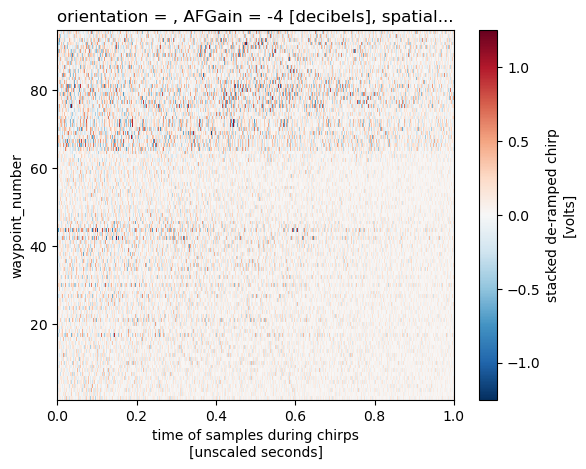

In [18]:
ds_reloaded.chirp_stacked.plot()

In [23]:
ds_reloaded

<xarray.Dataset> Size: 3GB
Dimensions:          (waypoint_number: 95, chirp_num: 100, chirp_time: 40001)
Coordinates: (12/13)
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    orientation      <U1 4B ''
    time             (waypoint_number) datetime64[ns] 760B 2023-12-25T23:50:5...
    filename         (waypoint_number) <U33 13kB '2023-12-25_235045-G1-21-05....
    waypoint_name    (waypoint_number) <U10 4kB 'G1-21-05' ... 'G5-15-05'
    ...               ...
    attenuator       (waypoint_number) float64 760B 26.0 30.0 26.0 ... 22.0 22.0
    lat              (waypoint_number) float64 760B -76.0 -76.0 ... -76.68 -76.7
    lon              (waypoint_number) float64 760B -107.6 -107.6 ... -108.0
    elevation        (waypoint_number) float64 760B nan nan ... 1.145e+03
    spatial_ref      int64 8B 0
  * waypoint_number  (waypoint_number) int64 760B 1 2 3 4 5 6 ... 91 92 93 94 95
Data variables:
    chirp            (waypoint_number, chirp_num, chirp_time) float64 3GB 0.0...
    battery_voltage  (waypoint_number) float64 760B 0.0 0.0 0.0 ... 12.73 12.7
    temperature_1    (waypoint_number) float64 760B -3.703 -1.937 ... -3.094
    temperature_2    (waypoint_number) float64 760B -2.875 -2.086 ... -5.336
    chirp_stacked    (waypoint_number, chirp_time) float64 30MB 0.02303 ... 0...
Attributes:
    processing:  Created on 2025-08-19 12:11:19.028247
    c:           300000000.0
    K:           200000000.0
    f_1:         200000000.0
    f_2:         400000000.0
    dt:          2.5e-05
    ep:          3.18
    B:           200000000.0
    f_c:         300000000.0

In [ ]:
# put in a pandas dataframe with the file names as the index
df_y1 = pd.DataFrame({'file': files, 'size': [os.path.getsize(f) for f in files]})
df_y2 = pd.DataFrame({'file': files_y2, 'size': [os.path.getsize(f) for f in files_y2]})
df_y1.to_excel('files_y1.xlsx', index=False)


# find those over 1 GB
df_y1_large = df_y1[df_y1['size'] > 10001252]
df_y2_large = df_y2[df_y2['size'] > 10001252]
df_y1_large

,file,size
46,/Users/jkingslake/Documents/data/thwaites_apre...,80083042
187,/Users/jkingslake/Documents/data/thwaites_apre...,16001444
213,/Users/jkingslake/Documents/data/thwaites_apre...,16001444


In [7]:
# get just the directory of 
os.path.dirname(df_y1_large.iloc[0,0])

'/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/G2-19-05'

In [221]:
ds_large_1 = xa.load.from_dats().load_all(os.path.dirname(df_y1_large.iloc[0,0]), attended=True, computeProfiles=False, disable_progress_bar = False)
ds_large_1

<xarray.Dataset> Size: 321MB
Dimensions:          (orientation: 1, waypoint: 1, chirp_num: 1001,
                      chirp_time: 40001)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 8B 2023-01-01T05:...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 8kB 0 1 2 3 4 5 ... 996 997 998 999 1000
    filename         (orientation, waypoint) <U30 120B '2023-01-01_052922_G2-...
    folder_name      (orientation, waypoint) <U8 32B 'G2-19-05'
    AFGain           int64 8B -4
    attenuator       float64 8B 23.0
  * orientation      (orientation) <U1 4B ''
  * waypoint         (waypoint) int64 8B 1
Data variables:
    chirp            (orientation, waypoint, chirp_num, chirp_time) float64 320MB ...
    latitude         (orientation, waypoint) float64 8B 0.0
    longitude        (orientation, waypoint) float64 8B 0.0
    battery_voltage  (orientation, waypoint) float64 8B 0.0
    temperature_1    (orientation, waypoint) float64 8B -8.68
    temperature_2    (orientation, waypoint) float64 8B -10.19
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000.0, 'f_...
    processing:  Created on 2025-08-19 09:44:57.012072

In [78]:
ds = xa.load.from_dats().load_all(path_y1[0], attended=True, computeProfiles=False, disable_progress_bar = False)
ds

<xarray.Dataset> Size: 32MB
Dimensions:          (orientation: 1, waypoint: 1, chirp_num: 100,
                      chirp_time: 40001)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 8B 2023-01-07T23:...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (orientation, waypoint) <U23 92B 'DATA2023-01-07-2303.DAT'
    folder_name      (orientation, waypoint) <U9 36B 'G8-06-263'
    AFGain           int64 8B -4
    attenuator       float64 8B 22.0
  * orientation      (orientation) <U1 4B ''
  * waypoint         (waypoint) int64 8B 1
Data variables:
    chirp            (orientation, waypoint, chirp_num, chirp_time) float64 32MB ...
    latitude         (orientation, waypoint) float64 8B 0.0
    longitude        (orientation, waypoint) float64 8B 0.0
    battery_voltage  (orientation, waypoint) float64 8B 0.0
    temperature_1    (orientation, waypoint) float64 8B 0.1406
    temperature_2    (orientation, waypoint) float64 8B 3.359
Attributes:
    constants:   {'c': 300000000.0, 'K': 200000000.0, 'f_1': 200000000.0, 'f_...
    processing:  Created on 2025-08-18 14:58:06.742342

In [14]:
ds_block.to_netcdf('test.nc')

## 3. add location info 

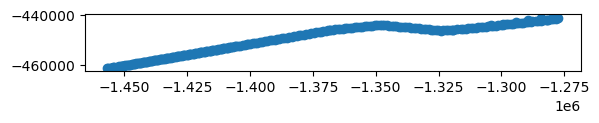

In [16]:
plt.plot(w.geometry.x, w.geometry.y, marker='o')
plt.gca().set_aspect('equal') 


<xarray.Dataset> Size: 96MB
Dimensions:          (waypoint: 3, chirp_num: 100, chirp_time: 40001)
Coordinates:
    time             (waypoint) datetime64[ns] 24B 2023-01-07T23:04:27 ... 20...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (waypoint) <U23 276B 'DATA2023-01-07-2303.DAT' ... 'DATA...
    folder_name      (waypoint) <U9 108B 'G8-06-263' 'G6-29-05' 'G5-33-05'
    AFGain           int64 8B -4
    attenuator       float64 8B 22.0
    orientation      <U1 4B ''
  * waypoint         (waypoint) int64 24B 1 2 3
    x                (waypoint) float64 24B -1.323e+06 -1.354e+06 -1.372e+06
    y                (waypoint) float64 24B -4.462e+05 -4.446e+05 -4.467e+05
    elevation        (waypoint) float64 24B 1.211e+03 1.204e+03 1.169e+03
Data variables:
    chirp            (waypoint, chirp_num, chirp_time) float64 96MB 0.01911 ....
    battery_voltage  (waypoint) float64 24B 0.0 0.0 0.0
    temperature_1    (waypoint) float64 24B 0.1406 -9.266 -10.44
    temperature_2    (waypoint) float64 24B 3.359 -9.594 -3.312
Attributes:
    processing:  Created on 2025-08-19 09:54:05.357488
    c:           300000000.0
    K:           200000000.0
    f_1:         200000000.0
    f_2:         400000000.0
    dt:          2.5e-05
    ep:          3.18
    B:           200000000.0
    f_c:         300000000.0

In [174]:
w.loc[waypoint_names[1],:].geometry.x

-1354373.402951369

In [ ]:
w = pd.read_csv("/Users/jkingslake/Documents/data/thwaites_apres/archiving/attended/centerline/single/2022-2023/positions.csv")

def add_XY_position(ds, xyz):
    waypoint_names = ds.folder_name.values.tolist()[0]


    return ds.assign_coords({xyz: ('waypoint', w.loc[waypoint_names,:].get_coordinates()[xyz])})

def add_Z_position(ds, xyz):
    waypoint_names = ds.folder_name.values.tolist()[0]


    return ds.assign_coords({'zcoord': ('waypoint', w.loc[waypoint_names,:].zcoord)})

In [163]:
x = [w.loc[name,:].geometry.x for name in waypoint_names]
x

TypeError: 'float' object is not subscriptable

In [291]:
w.to_file("waypoints.shp")

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_83343/4067931979.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  w.to_file("waypoints.shp")
/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Unnamed: 4' to 'Unnamed_ 4'
  ogr_write(
/Users/jkingslake/.local/share/mamba/envs/pdem_tools/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'interpolated?' to 'interpolat'
  ogr_write(


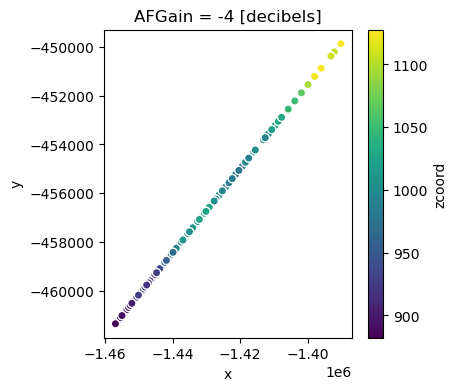

In [307]:
def add_XY_position(ds, xyz):
    waypoint_names = ds.folder_name.values.tolist()[0]


    return ds.assign_coords({xyz: ('waypoint', w.loc[waypoint_names,:].get_coordinates()[xyz])})

def add_Z_position(ds, xyz):
    waypoint_names = ds.folder_name.values.tolist()[0]


    return ds.assign_coords({'zcoord': ('waypoint', w.loc[waypoint_names,:].zcoord)})


y1_stacked = add_XY_position(y1_stacked, 'x')
y1_stacked = add_XY_position(y1_stacked, 'y')
y1_stacked = add_Z_position(y1_stacked, 'zcoord')

y2_stacked = add_XY_position(y2_stacked, 'x')
y2_stacked = add_XY_position(y2_stacked, 'y')
y2_stacked = add_Z_position(y2_stacked, 'zcoord')
y2_stacked.plot.scatter(x = 'x', y = 'y', hue = 'zcoord',  size = 4, aspect=1)

assert (y1_stacked.x == y2_stacked.x).all()

In [ ]:
w_interp = w.copy()
w_interp.insert(4, 'x_interp', False) 
w_interp.insert(5, 'interpolated?', np.nan) 

#x_interp = []
for I, row in enumerate(w_interp.itertuples()):
    if pd.isna(row.lon):
        #x_interp.append(  )
        w_interp.at[I, 'x_interp'] = np.mean(w_interp.iloc[[I-1,I+1]].get_coordinates()['x']) 
        #w_interp.at[I, 'lat'] = np.mean(w_interp.iloc[[I-1,I+1]].lat)
        #w_interp.at[I, 'elevation'] = np.mean(w_interp.iloc[[I-1,I+1]].elevation)
        #w_interp.at[I, 'interpolated?'] = True
    else:
        w_interp.at[I, 'x_interp'] = w_interp.iloc[I].get_coordinates()['x']

        w_interp.at[I, 'interpolated?'] = False
w_interp

AttributeError: 'Series' object has no attribute 'get_coordinates'

## Put the list of files in order based on thier position (we'll use the x UPS coordinate)

In [ ]:
w_sub = w.loc[waypoint,:]
x_sorted = w_sub.get_coordinates()['x'].sort_values()
waypoint_y1_sorted = w_sub.loc[x_sorted.index,:].index.to_list()
# make path names from waypoint names
path_y1 = [os.path.join(directory, wp) for wp in waypoint_y1_sorted]

- convert to UPS
- sort datasets by x_UPS
  

In [310]:
y2_stacked.x.max().values- y2_stacked.x.min().values, y2_stacked.y.max().values - y2_stacked.y.min().values

(np.float64(66639.07945277239), np.float64(11482.192632435123))

In [320]:
y1_stacked = y1_stacked.sortby('x')
y2_stacked = y2_stacked.sortby('x')

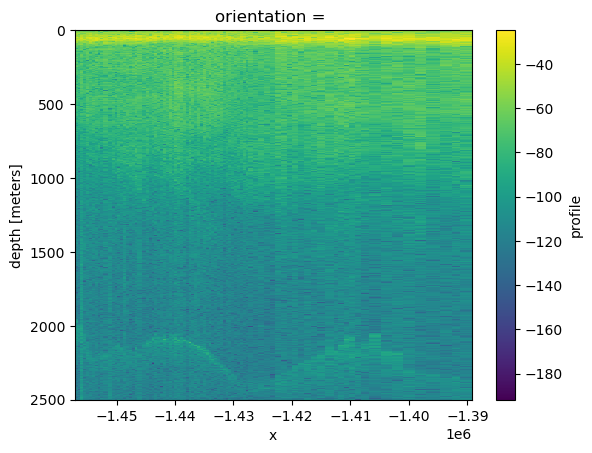

In [322]:
y1_stacked.profile.dB().squeeze().plot(x='x', ylim = (2500, 0))

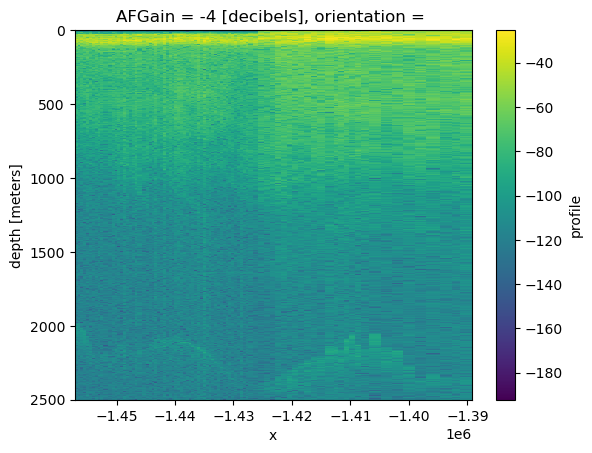

In [323]:
y2_stacked.profile.dB().squeeze().plot(x='x', ylim = (2500, 0))

In [338]:
d = xa.utils.compute_displacement(y1_stacked.profile, y2_stacked.profile, bin_size = 10)#.displacement.plot(x='x', ylim=(500,0), size=10)

In [341]:
d

<xarray.Dataset> Size: 136MB
Dimensions:                     (shot_number: 2, waypoint: 88, orientation: 1,
                                 profile_range: 39999, bin_depth: 3999)
Coordinates: (12/15)
    AFGain                      (shot_number, waypoint) int64 1kB -14 -4 ... -4
    attenuator                  (shot_number, waypoint) float64 1kB 15.0 ... ...
    filename                    (shot_number, orientation, waypoint) <U33 23kB ...
    folder_name                 (orientation, waypoint) <U8 3kB 'G1-21-05' .....
  * orientation                 (orientation) <U1 4B ''
    profile_time                (shot_number, orientation, waypoint) datetime64[ns] 1kB ...
    ...                          ...
    zcoord                      (waypoint) float64 704B 882.2 ... 1.128e+03
    x                           (waypoint) float64 704B -1.457e+06 ... -1.39e+06
    y                           (waypoint) float64 704B -4.614e+05 ... -4.499...
  * profile_range               (profile_range) float64 320kB 0.0 ... 8.411e+03
  * shot_number                 (shot_number) int64 16B 1 2
  * bin_depth                   (bin_depth) float64 32kB 0.9463 ... 8.408e+03
Data variables: (12/14)
    profile                     (shot_number, orientation, waypoint, profile_range) complex128 113MB ...
    coherence                   (orientation, waypoint, bin_depth) complex128 6MB ...
    phase                       (orientation, waypoint, bin_depth) float64 3MB ...
    phase_variance              (orientation, waypoint, bin_depth) float64 3MB ...
    displacement                (orientation, waypoint, bin_depth) float64 3MB ...
    disp_variance               (orientation, waypoint, bin_depth) float64 3MB ...
    ...                          ...
    strain_rate                 (waypoint) float64 704B -2.037e-06 ... -5.946...
    strain_rate_variance        (waypoint) float64 704B 3.896e-11 ... 1.415e-11
    surface_intercept           (waypoint) float64 704B 0.003552 ... 0.02146
    surface_intercept_variance  (waypoint) float64 704B 8.635e-06 ... 3.779e-06
    r_squared                   (waypoint) float64 704B 3.206e-05 ... 0.02018
    sum_squared_residuals       (waypoint) float64 704B 3.323e+03 ... 1.213e+04
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     10
    processing:   Created by the compute_displacement function in xapres usin...

In [340]:
d.sel(folder_name='G1-34-05')

KeyError: "no index found for coordinate 'folder_name'"

In [346]:
d.squeeze().set_xindex('folder_name').sel(folder_name='G1-34-05')

<xarray.Dataset> Size: 2MB
Dimensions:                     (shot_number: 2, profile_range: 39999,
                                 bin_depth: 3999)
Coordinates: (12/15)
    AFGain                      (shot_number) int64 16B -4 -4
    attenuator                  (shot_number) float64 16B 26.0 26.0
    filename                    (shot_number) <U33 264B '2022-12-31_051011_G1...
    folder_name                 <U8 32B 'G1-34-05'
    orientation                 <U1 4B ''
    profile_time                (shot_number) datetime64[ns] 16B 2022-12-31T0...
    ...                          ...
    zcoord                      float64 8B 912.3
    x                           float64 8B -1.451e+06
    y                           float64 8B -4.603e+05
  * profile_range               (profile_range) float64 320kB 0.0 ... 8.411e+03
  * shot_number                 (shot_number) int64 16B 1 2
  * bin_depth                   (bin_depth) float64 32kB 0.9463 ... 8.408e+03
Data variables: (12/14)
    profile                     (shot_number, profile_range) complex128 1MB (...
    coherence                   (bin_depth) complex128 64kB (-0.9338703818448...
    phase                       (bin_depth) float64 32kB 3.046 -0.8946 ... 1.346
    phase_variance              (bin_depth) float64 32kB 0.08798 1.228 ... 0.788
    displacement                (bin_depth) float64 32kB 0.1359 ... 0.06006
    disp_variance               (bin_depth) float64 32kB 0.0001752 ... 0.001569
    ...                          ...
    strain_rate                 float64 8B -1.873e-05
    strain_rate_variance        float64 8B 3.742e-11
    surface_intercept           float64 8B 0.004864
    surface_intercept_variance  float64 8B 8.374e-06
    r_squared                   float64 8B 0.002868
    sum_squared_residuals       float64 8B 3.261e+03
Attributes:
    long_name:    profile
    units:        -
    description:  Time series of profiles of coherence, phase, displacement, ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...
    bin_size:     10
    processing:   Created by the compute_displacement function in xapres usin...

In [39]:
array_plan = rechunk(source = ds_y1, 
                     target_chunks = {'chirp_num':100,'chirp_time':-1}, 
                     max_mem = "5000MB", 
                     target_store = "zarrs_both/y1_rechunked2.zarr",
                     temp_store='rechunking_temp/temp.zarr')
array_plan.execute()
zarr.consolidate_metadata("zarrs_both/y1_rechunked.zarr")
ds_y1 = xr.open_dataset('zarrs_both/y1_rechunked.zarr', engine='zarr', chunks = {}, decode_timedelta=False)


2025-06-12 19:12:07,565 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 5.06 GiB -- Worker memory limit: 6.00 GiB
2025-06-12 19:12:07,568 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.31 GiB -- Worker memory limit: 6.00 GiB
2025-06-12 19:12:08,142 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.29 GiB -- Worker memory limit: 6.00 GiB
2025-06-12 19:12:08,813 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memo

KilledWorker: Attempted to run task ('copy_read_to_write-dc04b660239f56319acac5fc7a5745d2', 4) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:60321. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
array_plan = rechunk(source = ds_y2, 
                     target_chunks = {'chirp_num':100,'chirp_time':-1}, 
                     max_mem = "5000MB", 
                     target_store = "zarrs_both/y2_rechunked.zarr",
                     temp_store='rechunking_temp/temp.zarr')
array_plan.execute()
zarr.consolidate_metadata("zarrs_both/y2_rechunked.zarr")
ds_y2 = xr.open_dataset('zarrs_both/y2_rechunked.zarr', engine='zarr', chunks = {}, decode_timedelta=False)


<zarr.hierarchy.Group '/'>

In [35]:
ds_y1.chirp

<xarray.DataArray 'chirp' (orientation: 1, waypoint: 88, chirp_num: 1001,
                           chirp_time: 40001)> Size: 28GB
dask.array<open_dataset-chirp, shape=(1, 88, 1001, 40001), dtype=float64, chunksize=(1, 6, 100, 40001), chunktype=numpy.ndarray>
Coordinates:
    AFGain       (waypoint) int64 704B dask.array<chunksize=(88,), meta=np.ndarray>
    attenuator   (waypoint) float64 704B dask.array<chunksize=(88,), meta=np.ndarray>
  * chirp_num    (chirp_num) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999 1000
  * chirp_time   (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
    filename     (orientation, waypoint) <U33 12kB dask.array<chunksize=(1, 88), meta=np.ndarray>
    folder_name  (orientation, waypoint) <U8 3kB dask.array<chunksize=(1, 88), meta=np.ndarray>
  * orientation  (orientation) <U1 4B ''
    time         (orientation, waypoint) datetime64[ns] 704B dask.array<chunksize=(1, 88), meta=np.ndarray>
  * waypoint     (waypoint) int64 704B 1 2 3 4 5 6 7 8 ... 82 83 84 85 86 87 88
Attributes:
    description:  voltage from the analog-to-digital converter after the rece...
    long_name:    de-ramped chirp
    units:        volts

In [ ]:
ds_y2_stacked = ds_y2.mean(dim='chirp_num')
ds_y2_stacked.compute()

In [32]:
ds_y2_stacked = ds_y2.mean(dim='chirp_num')
ds_y2_stacked.compute()

<xarray.Dataset> Size: 29MB
Dimensions:          (waypoint: 88, orientation: 1, chirp_time: 40001)
Coordinates:
    AFGain           (waypoint) int64 704B -4 -4 -4 -4 -4 -4 ... -4 -4 -4 -4 -4
    attenuator       (waypoint) float64 704B 26.0 30.0 20.0 ... 26.0 26.0 26.0
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
    filename         (orientation, waypoint) <U33 12kB 'DATA2023-01-02-0128_G...
    folder_name      (orientation, waypoint) <U8 3kB 'G2-38-05' ... 'G1-35-05'
  * orientation      (orientation) <U1 4B ''
    time             (orientation, waypoint) datetime64[ns] 704B 2023-01-02T0...
  * waypoint         (waypoint) int64 704B 1 2 3 4 5 6 7 ... 83 84 85 86 87 88
Data variables:
    battery_voltage  (orientation, waypoint) float64 704B 0.0 0.4189 ... 0.06848
    chirp            (orientation, waypoint, chirp_time) float64 28MB 0.02631...
    latitude         (orientation, waypoint) float64 704B 0.0 0.0 ... 0.0 0.0
    longitude        (orientation, waypoint) float64 704B 0.0 0.0 ... 0.0 0.0
    temperature_1    (orientation, waypoint) float64 704B -2.406 13.87 ... -1.82
    temperature_2    (orientation, waypoint) float64 704B -2.531 ... -4.297

In [8]:
ds_y1_chunked = ds_y1.chunk(waypoint = 8, chirp_num = 100)
ds_y2_chunked = ds_y2.chunk(waypoint = 8, chirp_num = 100)

In [13]:
ds_y1_chunked.nbytes/1e9, ds_y2_chunked.nbytes/1e9

(28.189213492, 2.816411284)

In [ ]:
ds_y1_stacked_100 = ds_y1_chunked.isel(chirp_num=slice(0,100)).mean(dim='chirp_num').compute()

/Users/jkingslake/miniconda3/envs/new_xarray/lib/python3.13/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 2.62 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [15]:
ds_y2_stacked_100 = ds_y2_chunked.isel(chirp_num=slice(0,-1)).mean(dim='chirp_num').compute()

/Users/jkingslake/miniconda3/envs/new_xarray/lib/python3.13/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 2.62 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [51]:
d1 = ds_y1_stacked_100.addProfileToDs()
d2 = ds_y2_stacked_100.addProfileToDs()

In [ ]:
disp = xa.utils.compute_displacement(d1.profile, d2.profile, bin_size = 400).squeeze()

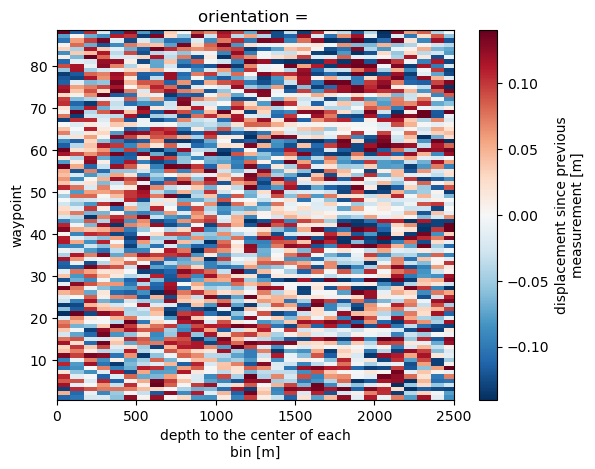

In [64]:
disp.displacement.plot(xlim=(0,2500))

## 3. add location info 

In [60]:
Waypoints_GHOST2022_2023 = pd.read_excel("/Users/jkingslake/Documents/data/thwaites_apres/2022-2023/Waypoints_GHOST2022-2023.xlsx", sheet_name = 'waypoint-gps')
Waypoints_GHOST2022_2023

,Waypoint,xcoord,ycoord,zcoord,Unnamed: 4
0,G1-21-05,-107.571318,-76.002191,882.202698,NaN
1,G1-22-05,NaN,NaN,890.111603,interp
2,G1-23-05,-107.576420,-76.011062,898.020508,NaN
3,G1-24-05,-107.579000,-76.015486,892.305969,NaN
4,G1-25-05,-107.581394,-76.019930,892.733093,NaN
...,...,...,...,...,...
230,221,-109.029264,-77.571790,1357.663574,NaN
231,220,-109.037602,-77.580705,1346.282715,NaN
232,219,-109.045977,-77.589632,1340.057617,NaN
233,218,-109.054292,-77.598552,1318.649536,NaN


In [62]:
def add_latlon(ds):
    Waypoints_GHOST2022_2023 = pd.read_excel("/Users/jkingslake/Documents/data/thwaites_apres/2022-2023/Waypoints_GHOST2022-2023.xlsx", sheet_name = 'waypoint-gps')
    lat = []
    lon = []
    for fol in ds.folder_name.values.squeeze():
        print(fol)
        lat.append(Waypoints_GHOST2022_2023[Waypoints_GHOST2022_2023['Waypoint'] == fol].ycoord.values)
        lon.append(Waypoints_GHOST2022_2023[Waypoints_GHOST2022_2023['Waypoint'] == fol].xcoord.values)

    
    return ds.assign_coords(lat = ("waypoint", lat))
add_latlon(ds_all_y2)

G2-38-05
G1-22-05
G3-36-05
G3-02-05
G3-12-05
G2-28-05
G2-08-05
G3-06-05
G3-32-05
G1-26-05
G1-36-05
G3-16-05
G2-18-05
G2-09-05
G1-27-05
G1-37-05
G3-23-05
G2-19-05
G4-08-05
G2-39-05
G1-23-05
G1-33-05
G2-29-05
G1-28-05
G2-32-05
G3-08-05
G2-06-05
G2-16-05
G3-18-05
G2-22-05
G1-38-05
G2-02-05
G3-38-05
G2-36-05
G2-26-05
G2-12-05
G2-37-05
G4-32-05
G4-16-05
G2-27-05
G3-29-05
G2-13-05
G1-29-05
G2-33-05
G2-07-05
G4-36-05
G4-12-05
G2-17-05
G2-23-05
G1-39-05
G3-26-06
G2-34-05
G2-24-05
G2-10-05
G2-41-05
G2-30-05
G2-04-05
G2-14-05
G2-20-05
G2-31-05
G2-05-05
G4-24-05
G2-15-05
G2-21-05
G2-01-05
G2-35-05
G4-04-05
G4-30-05
G4-20-05
G2-25-05
G2-11-05
G2-40-05
G1-41-05
G3-04-05
G1-24-05
G3-30-05
G3-20-05
G1-34-05
G3-14-05
G3-34-05
G3-10-05
G1-30-05
G3-24-05
G1-21-05
G3-40-05
G1-31-05
G1-40-05
G1-25-05
G1-35-05


ValueError: Variable 'lat': Could not convert tuple of form (dims, data[, attrs, encoding]): ('waypoint', [array([-76.25960497]), array([nan]), array([-76.43266797]), array([-76.28176798]), array([-76.32617597]), array([-76.21523897]), array([-76.12641603]), array([-76.29955396]), array([-76.41490404]), array([-76.02435504]), array([-76.06873998]), array([-76.34396003]), array([-76.17085302]), array([-76.13089004]), array([-76.028807]), array([-76.07317401]), array([nan]), array([-76.17525796]), array([-76.48587998]), array([-76.26406699]), array([-76.01106201]), array([-76.05545199]), array([-76.21967903]), array([nan]), array([-76.23300601]), array([-76.30842696]), array([-76.11758804]), array([-76.16194398]), array([-76.35280604]), array([-76.18860397]), array([-76.07763402]), array([-76.09982402]), array([-76.44152898]), array([-76.25074999]), array([-76.20636798]), array([-76.144186]), array([-76.25519601]), array([-76.59240098]), array([-76.52136996]), array([-76.21080402]), array([-76.40161302]), array([-76.148644]), array([-76.03764597]), array([-76.23742998]), array([-76.12200899]), array([-76.61012099]), array([-76.50364299]), array([-76.166405]), array([-76.19305803]), array([-76.08204399]), array([], dtype=float64), array([-76.24184598]), array([-76.19746003]), array([-76.13532398]), array([-76.27291401]), array([-76.22413301]), array([-76.10864698]), array([-76.15308699]), array([-76.17968604]), array([-76.22855597]), array([-76.11317002]), array([-76.55685802]), array([-76.15753703]), array([-76.18414002]), array([-76.09536502]), array([-76.24629401]), array([-76.46814798]), array([-76.58348196]), array([-76.53912602]), array([-76.20193002]), array([-76.139699]), array([-76.268483]), array([-76.090962]), array([-76.29065003]), array([-76.01548598]), array([-76.40598401]), array([-76.36166998]), array([-76.05988601]), array([-76.33504897]), array([-76.42377997]), array([-76.31729803]), array([nan]), array([-76.37941204]), array([-76.00219103]), array([-76.45038798]), array([-76.046594]), array([-76.08646796]), array([-76.01992998]), array([-76.06432096])]) to Variable.

In [36]:
Waypoints_GHOST2022_2023 = pd.read_excel("/Users/jkingslake/Documents/data/thwaites_apres/2022-2023/Waypoints_GHOST2022-2023.xlsx", sheet_name = 'waypoint-gps')

In [63]:
list(ds_all_y2.folder_name.values.squeeze())


['G2-38-05',
 'G1-22-05',
 'G3-36-05',
 'G3-02-05',
 'G3-12-05',
 'G2-28-05',
 'G2-08-05',
 'G3-06-05',
 'G3-32-05',
 'G1-26-05',
 'G1-36-05',
 'G3-16-05',
 'G2-18-05',
 'G2-09-05',
 'G1-27-05',
 'G1-37-05',
 'G3-23-05',
 'G2-19-05',
 'G4-08-05',
 'G2-39-05',
 'G1-23-05',
 'G1-33-05',
 'G2-29-05',
 'G1-28-05',
 'G2-32-05',
 'G3-08-05',
 'G2-06-05',
 'G2-16-05',
 'G3-18-05',
 'G2-22-05',
 'G1-38-05',
 'G2-02-05',
 'G3-38-05',
 'G2-36-05',
 'G2-26-05',
 'G2-12-05',
 'G2-37-05',
 'G4-32-05',
 'G4-16-05',
 'G2-27-05',
 'G3-29-05',
 'G2-13-05',
 'G1-29-05',
 'G2-33-05',
 'G2-07-05',
 'G4-36-05',
 'G4-12-05',
 'G2-17-05',
 'G2-23-05',
 'G1-39-05',
 'G3-26-06',
 'G2-34-05',
 'G2-24-05',
 'G2-10-05',
 'G2-41-05',
 'G2-30-05',
 'G2-04-05',
 'G2-14-05',
 'G2-20-05',
 'G2-31-05',
 'G2-05-05',
 'G4-24-05',
 'G2-15-05',
 'G2-21-05',
 'G2-01-05',
 'G2-35-05',
 'G4-04-05',
 'G4-30-05',
 'G4-20-05',
 'G2-25-05',
 'G2-11-05',
 'G2-40-05',
 'G1-41-05',
 'G3-04-05',
 'G1-24-05',
 'G3-30-05',
 'G3-20-05',

In [ ]:
Waypoints_GHOST2022_2023.Waypoint
# subset the Waypint to only those in a list
only_repeated_points = Waypoints_GHOST2022_2023[Waypoints_GHOST2022_2023.Waypoint.isin(list(ds_all_y2.folder_name.values.squeeze()))]

In [38]:
points = gpd.GeoDataFrame(Waypoints_GHOST2022_2023, geometry=gpd.points_from_xy(Waypoints_GHOST2022_2023.xcoord, Waypoints_GHOST2022_2023.ycoord))
points = points.set_crs('EPSG:4326')
points

,Waypoint,xcoord,ycoord,zcoord,Unnamed: 4,geometry
0,G1-21-05,-107.571318,-76.002191,882.202698,NaN,POINT (-107.57132 -76.00219)
1,G1-22-05,NaN,NaN,890.111603,interp,POINT EMPTY
2,G1-23-05,-107.576420,-76.011062,898.020508,NaN,POINT (-107.57642 -76.01106)
3,G1-24-05,-107.579000,-76.015486,892.305969,NaN,POINT (-107.57900 -76.01549)
4,G1-25-05,-107.581394,-76.019930,892.733093,NaN,POINT (-107.58139 -76.01993)
...,...,...,...,...,...,...
230,221,-109.029264,-77.571790,1357.663574,NaN,POINT (-109.02926 -77.57179)
231,220,-109.037602,-77.580705,1346.282715,NaN,POINT (-109.03760 -77.58070)
232,219,-109.045977,-77.589632,1340.057617,NaN,POINT (-109.04598 -77.58963)
233,218,-109.054292,-77.598552,1318.649536,NaN,POINT (-109.05429 -77.59855)


In [ ]:
# to shape file
points.to_file("/Users/jkingslake/Documents/data/thwaites_apres/2022-2023/Waypoints_GHOST2022-2023.shp")

In [41]:
only_repeated_points = points[points.Waypoint.isin(list(ds_all_y2.folder_name.values.squeeze()))]
only_repeated_points.to_file("/Users/jkingslake/Documents/data/thwaites_apres/2022-2023/only_repeated_points.shp")


In [18]:
ds_y2.folder_name.values == ds_y1.folder_name.values

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True]])

In [37]:
p1


<xarray.DataArray 'profile' (orientation: 1, waypoint: 88, profile_range: 39999)> Size: 56MB
array([[[ 3.62969082e-04+0.00000000e+00j,
          2.35957555e-06+3.15706727e-04j,
         -2.02605587e-04+7.52211376e-07j, ...,
          1.01002179e-07+1.53268286e-07j,
         -8.17661300e-08+1.34979371e-07j,
         -1.93473020e-07-2.60732295e-08j],
        [-1.40036344e-04+0.00000000e+00j,
         -3.41351543e-07-1.27584867e-04j,
          9.60057006e-05-1.40539484e-06j, ...,
          1.26965461e-07-1.99025867e-07j,
          1.64796048e-07+1.35803331e-07j,
         -1.09185607e-07+1.08278450e-07j],
        [-6.58205698e-06+0.00000000e+00j,
          1.09360988e-05-5.42842197e-06j,
          7.06624958e-06+5.50599793e-06j, ...,
         -1.39952106e-07+2.39707510e-07j,
         -2.07357483e-07-2.96926980e-07j,
          4.58480343e-07-1.33241221e-07j],
        ...,
        [ 1.88703544e-04+0.00000000e+00j,
          1.45696582e-05+1.68631411e-04j,
         -1.14253732e-04+9.51218961e-06j, ...,
         -4.63919875e-08-3.38801079e-09j,
          5.12660611e-08-5.46784900e-08j,
          7.24330683e-08+7.63503026e-08j],
        [ 2.07914327e-04+0.00000000e+00j,
          2.35412453e-08+1.78340091e-04j,
         -1.07895760e-04-2.72542569e-06j, ...,
          4.08951585e-08-9.74068042e-08j,
          3.59034901e-07-4.24253815e-08j,
          5.76073076e-08+4.70477910e-07j],
        [-2.20202282e-06+0.00000000e+00j,
          1.46915972e-05+1.88365158e-06j,
         -4.19747005e-06+7.89585280e-06j, ...,
          4.52541780e-07+3.01944836e-07j,
         -2.89006033e-07+3.53515930e-07j,
         -4.31726166e-08-2.42913069e-07j]]])
Coordinates:
  * orientation    (orientation) <U1 4B ''
  * waypoint       (waypoint) int64 704B 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88
    time           (orientation, waypoint) datetime64[ns] 704B 2023-01-02T01:...
    filename       (orientation, waypoint) <U33 12kB 'DATA2023-01-02-0128_G2-...
    folder_name    (orientation, waypoint) <U8 3kB 'G2-38-05' ... 'G1-35-05'
    AFGain         (waypoint) int64 704B -4 -4 -4 -4 -4 -4 ... -4 -4 -4 -4 -4
    attenuator     (waypoint) float64 704B 26.0 30.0 20.0 ... 26.0 26.0 26.0
  * profile_range  (profile_range) float64 320kB 0.0 0.2103 ... 8.411e+03
Attributes:
    long_name:    profile
    units:        -
    description:  complex profile computed from the fourier transform of the ...
    constants:    {'T': 1, 'f_1': 200000000.0, 'f_2': 400000000.0, 'B': 20000...

In [17]:
one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False)

100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


In [18]:
print(f"total size of dataset without profiles computed = {one_dat.nbytes/1e9 * len(filepaths):.2f} GB")

total size of dataset without profiles computed = 11.64 GB


In [10]:
ds = tg_1.load_all(directory = dat_directory, computeProfiles = False, file_numbers_to_process=list(range(0,5)))

100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


<xarray.DataArray 'time' (time: 12)> Size: 96B
array(['2023-01-16T05:42:03.000000000', '2023-01-16T05:53:54.000000000',
       '2023-01-16T06:05:31.000000000', '2023-01-16T06:20:39.000000000',
       '2023-01-17T06:20:25.000000000', '2023-01-18T06:20:33.000000000',
       '2023-01-19T06:20:25.000000000', '2023-01-20T06:20:45.000000000',
       '2023-01-21T06:21:06.000000000', '2023-01-22T06:20:56.000000000',
       '2023-01-23T06:20:56.000000000', '2023-01-24T06:20:56.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 96B 2023-01-16T05:42:03 ... 2023-01-2...
    filename      (time) <U92 4kB 'gs://ldeo-glaciology/apres/thwaites/contin...
    burst_number  (time) int64 96B 0 0 0 0 1 2 3 4 5 6 0 1
    orientation   (time) <U7 336B 'unknown' 'unknown' ... 'unknown' 'unknown'

In at least one of the sites, the first few dat files contain data collected using different attenuator settings, so we skip those, because they cant easily be concatenated with the rest of the data and they are likely just test shots taken on the day of installation. 

In another site some dat files are from much earlier (2002?)

In [11]:
if site == 'ApRES_Lake1':
    start_dat_file_number = 3  # the first 3 use different attenuator settings. 
elif site == 'ApRES_LTG': 
    start_dat_file_number = 4  # the first 4 use te same attenuator settings, but they are not regularly spaces in time with the other data
elif site == 'ApRES_Lake2':
    start_dat_file_number = 3

In [8]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})

## Load all and save to zarr
Load all the data from this site into local memory, without computing the profiles, then save it back to local sotrage as a zarr. 

Computing all the profiles is an expensive operation, so we would like to use a dask cluster. But to use the cluster, this needs to be a dask array. This is a way of solving that because the zarr that it creates can be loaded to get the data loaded lazily. 



In [12]:
raw_ds_location = f'zarrs/{site}'

if site == 'ApRES_Lake2':
    N = (len(filepaths)-start_dat_file_number)//2 + start_dat_file_number 
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(start_dat_file_number, N)))
    ds.to_zarr(raw_ds_location)  
    
    del ds
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(N, len(filepaths))))
    ds.to_zarr(raw_ds_location, append_dim='time')  
    
else:
    
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(start_dat_file_number,len(filepaths))))
    ds.to_zarr(raw_ds_location)
#print(ds.nbytes/1e9)

100%|██████████| 177/177 [08:51<00:00,  3.00s/it]


In [13]:
#with performance_report('report.html'):


## Load from zarr
To get a lazily loaded dataset containing dask arrays, we load from 

In [14]:
r = load_zarr(raw_ds_location)

The result is a dataset containing dask arrays. 


## Rechunk
A remaining issue is that the data is chunked in the `chirp_time` dimension. The fft step of computing the profiles requires the data to not be chunked in this dimension. 

We use rechunker to rechunk to the following chunks sizes: (23, 40001, 10, 1), following this guide: https://rechunker.readthedocs.io/en/latest/tutorial.html#Rechunk-a-Group

First we step up a temporary location to store data and the final target location. For the temp location we use the local disk, for the target locations we make a directory in the google bucket where the data is stored. Note we could also use the scratch bucket in cryocloud if we are running this there. I am not sure if is faster to use that or the 'local' space wheer the notebook is running. Both seem to work ok. 

In [15]:
with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

filename = root + "/zarr/rechunked.zarr"
target_store = fsspec.get_mapper(filename, mode='w', token=token)

# we could use the scratch bucket on cryocloud...
#scratch = os.environ['SCRATCH_BUCKET']
#temp_store = fsspec.get_mapper(scratch + "temp.zarr", mode='w')
# ... or our local space
temp_store = "zarrs_rechunked_temp.zarr"
!rm -rf zarrs_rechunked_temp.zarr

Next, define the source as the zarr that we just wrote, and reload is as `ds` just to be sure we are using exactly the same info as is saved int here for the chunking. 

In [16]:
source_store = raw_ds_location
ds = xr.open_dataset(source_store,
            engine = 'zarr', 
            chunks = {})
source_group = zarr.open(source_store)

Define the chunking scheme. We only want to rechunk the 'chirp'variable'.
We create a dictionay with the data variables and coordinates as keys and `None` for the values, then replace the 'chirp' entry with another dictionary describing the desired chunking. 

In [17]:
target_chunks = {var: None for var in dict(ds.data_vars) | dict(ds.coords)}

chirp_chunk_sizes_dict = {dim: chunks[0] for dim, chunks in zip(ds.chirp.dims, ds.chirp.chunks)}
chirp_chunk_sizes_dict['chirp_time'] = ds.chirp_time.shape[0]
chirp_chunk_sizes_dict['chirp_num'] = 10

target_chunks["chirp"] =  chirp_chunk_sizes_dict
#target_chunks = chirp_chunk_sizes_dict

# need to remove the existing stores or it won't work
!rm -rf zarrs_rechunked/*
array_plan = rechunk(source = source_group, 
                     target_chunks = target_chunks, 
                     max_mem = "200MB", 
                     target_store = target_store,
                     temp_store=temp_store)
array_plan

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [18]:
with ProgressBar():
    array_plan.execute()
zarr.consolidate_metadata(target_store)

<zarr.hierarchy.Group '/'>

In [19]:
r_reload = load_zarr(target_store)
#r_reload.chirp.chunks

Plot the pofiles to estimate an appropriate max_depth to use. 2500 m appears reasonable as the bed is just below 2000m in the plot below. 

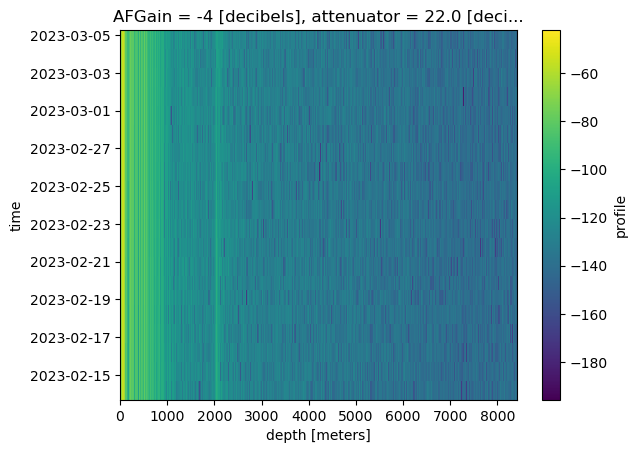

In [20]:
r_reload.chirp.mean(dim='chirp_num').isel(time = slice(30,50)).computeProfile().dB().plot()

## Add profiles
Add profiles to the dataset and compute stacked chirps and profiles. 

In [21]:
full = r_reload.addProfileToDs(max_range = 2500)
profile_stacked = full.profile.mean(dim='chirp_num')
chirp_stacked = full.chirp.mean(dim='chirp_num')
full_stacked = full.assign({'profile_stacked': profile_stacked, 'chirp_stacked': chirp_stacked})

## Write to zarr
Write the final result to a zarr in the google bucket. 

In [22]:
filename = root + '/zarr/full.zarr'
mapper = fsspec.get_mapper(filename, mode='w', token=token)

full_stacked.to_zarr(mapper)

In [23]:
f = load_zarr(mapper)
f

<xarray.Dataset> Size: 18GB
Dimensions:          (attenuator_setting_pair: 1, time: 351, chirp_time: 40001,
                      chirp_num: 100, profile_range: 11889)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U90 126kB dask.array<chunksize=(351,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(351,), meta=np.ndarray>
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * time             (time) datetime64[ns] 3kB 2023-01-16T00:52:00 ... 2023-1...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 11GB dask.array<chunksize=(22, 40001, 10, 1), meta=np.ndarray>
    chirp_stacked    (time, chirp_time, attenuator_setting_pair) float64 112MB dask.array<chunksize=(22, 40001, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 7GB dask.array<chunksize=(22, 10, 1, 11889), meta=np.ndarray>
    profile_stacked  (time, attenuator_setting_pair, profile_range) complex128 67MB dask.array<chunksize=(22, 1, 11889), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-21 15:30:22.044429

In [24]:
print('everything completed ok and you should find ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr in the bucket')

everything completed ok and you should find ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr in the bucket


In [15]:
full_stacked.profile_stacked.load()

<xarray.DataArray 'profile_stacked' (time: 362, attenuator_setting_pair: 1,
                                     profile_range: 11889)> Size: 69MB
array([[[ 6.68002374e-03+0.00000000e+00j,
          3.64323551e-07+5.88457083e-03j,
         -3.97115910e-03+7.95787624e-07j, ...,
         -3.13873729e-07-3.60635519e-07j,
         -1.23389765e-07-4.16351413e-07j,
          5.59941971e-07-5.69340573e-07j]],

       [[ 6.69701978e-03+0.00000000e+00j,
         -1.19533060e-08+5.89933100e-03j,
         -3.98061215e-03+3.29834417e-07j, ...,
         -6.32162487e-07-3.06725506e-07j,
         -1.07168776e-07-5.24138656e-07j,
          3.87862228e-07-6.00727497e-07j]],

       [[ 6.69241659e-03+0.00000000e+00j,
          6.34100040e-08+5.89531487e-03j,
         -3.97798407e-03+4.19429211e-07j, ...,
         -1.93632186e-07-2.46644366e-07j,
          8.28425792e-08-2.96162017e-07j,
          3.76199746e-07-2.23067560e-07j]],
...
       [[ 6.66799118e-03+0.00000000e+00j,
          3.17788725e-06+5.87527973e-03j,
         -3.96721061e-03+4.26932617e-06j, ...,
          9.53348254e-07-6.71366218e-07j,
          9.29607395e-07+5.62604727e-07j,
         -8.86125569e-08+9.09786342e-07j]],

       [[ 6.66627886e-03+0.00000000e+00j,
          3.20669524e-06+5.87380920e-03j,
         -3.96624618e-03+4.25959342e-06j, ...,
          9.02973802e-07-3.31087780e-07j,
          4.74961702e-07+7.07892626e-07j,
         -3.94728744e-07+4.56977899e-07j]],

       [[ 6.66697204e-03+0.00000000e+00j,
          3.21395190e-06+5.87440511e-03j,
         -3.96663790e-03+4.31102171e-06j, ...,
          1.24010024e-06+1.00643497e-07j,
          7.87174834e-08+9.72338634e-07j,
         -5.74623030e-07+3.02553256e-07j]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 8B -14
    attenuator     (attenuator_setting_pair) float64 8B 6.0
    burst_number   (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 1 0 1 0 1 0 1 0 1 0
    filename       (time) <U92 133kB 'gs://ldeo-glaciology/apres/thwaites/con...
    orientation    (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time           (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-01-...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

In [17]:
full_stacked.profile_stacked.nbytes/1e6

69.812208

In [18]:
dB = full_stacked.profile_stacked.isel(time=slice(5,-1)).dB().load()

KeyboardInterrupt: 

In [19]:
dB

<xarray.DataArray 'profile_stacked' (time: 356, attenuator_setting_pair: 1,
                                     profile_range: 11889)> Size: 34MB
array([[[ -43.47478601,  -44.57611776,  -47.99258849, ...,
         -134.26285621, -128.01299281, -122.21411856]],

       [[ -43.47912211,  -44.580411  ,  -47.99670598, ...,
         -126.68280657, -126.50316807, -128.39706169]],

       [[ -43.48366422,  -44.58493209,  -48.00117005, ...,
         -122.41687615, -121.92955264, -122.60269614]],

       ...,

       [[ -43.51903353,  -44.61830927,  -48.02907053, ...,
         -120.1790747 , -124.94936918, -133.7758992 ]],

       [[ -43.52009967,  -44.61942775,  -48.03028984, ...,
         -118.6658709 , -119.27862648, -120.78020606]],

       [[ -43.52233047,  -44.621602  ,  -48.03240165, ...,
         -120.33867279, -121.38644488, -124.3813619 ]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 8B -14
    attenuator     (attenuator_setting_pair) float64 8B 6.0
    burst_number   (time) int64 3kB 1 0 1 0 1 0 1 0 1 0 ... 0 1 0 1 0 1 0 1 0 1
    filename       (time) <U92 131kB 'gs://ldeo-glaciology/apres/thwaites/con...
    orientation    (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time           (time) datetime64[ns] 3kB 2023-01-21T04:22:47 ... 2024-01-...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

In [30]:
site_for_reload = 'ApRES_Lake1'
filename_for_reload = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site_for_reload}/zarr/full.zarr"
mapper = fsspec.get_mapper(filename_for_reload, mode='w', token=token)
r_lake1 = load_zarr(mapper)

site_for_reload = 'ApRES_LTG'
filename_for_reload = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site_for_reload}/zarr/full_2"
mapper = fsspec.get_mapper(filename_for_reload, mode='w', token=token)
r_LTG = load_zarr(mapper)

In [33]:
r_lake1.dims

FrozenMappingWarningOnValuesAccess({'attenuator_setting_pair': 1, 'time': 362, 'chirp_time': 40001, 'chirp_num': 100, 'profile_range': 11889})

In [34]:
r_LTG.dims

FrozenMappingWarningOnValuesAccess({'attenuator_setting_pair': 1, 'time': 355, 'chirp_time': 40001, 'chirp_num': 100, 'profile_range': 11889})

/tmp/ipykernel_6182/1634667285.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


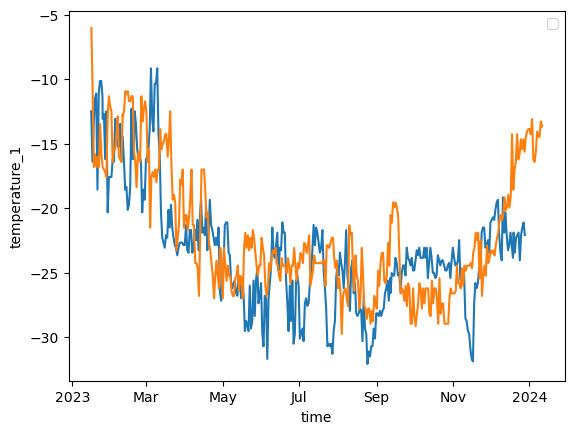

In [42]:
import matplotlib.pyplot as plt
r_LTG.isel(time=slice(4,-1)).temperature_1.plot()
r_lake1.temperature_1.plot()
plt.legend()
